In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import sys
import os
import torch.nn.functional as F

sys.path.append(os.path.abspath('/app/src/lib')) #import Dataloader
sys.path.append(os.path.abspath('/app/src')) #for config

from seed_everything import seed_everything
import config
config.HEADLESS_PLOT = False
import utils

seed_everything(config.SEED)

# --- CONFIGURATION ---
WINDOW_SIZE = 512          # Your TARGET_FLAG_LENGTH
TARGET_SIZE = 512 # The FLAG_LENGTH the model uses
STRIDE = 10                 # 1 = Check every single step (smoothest, but slowest)
CONFIDENCE_THRESHOLD = 0.55 # Only classify if softmax prob > 70%
BATCH_SIZE = config.BATCH_SIZE

# Define your classes and their colors for the plot
# Using the classes you mentioned earlier
CLASS_CONFIG = {
    0: {'name': 'Bearish Normal',  'color': 'red'},
    1: {'name': 'Bearish Pennant', 'color': 'darkred'},
    2: {'name': 'Bearish Wedge',   'color': 'orangered'},
    3: {'name': 'Bullish Normal',  'color': 'green'},
    4: {'name': 'Bullish Pennant', 'color': 'lime'},
    5: {'name': 'Bullish Wedge',   'color': 'forestgreen'}
}

def preprocess_window(price_array, TARGET_LENGTH):
    # 1. Normalize
    seq_numpy = price_array.astype(np.float32)
    if seq_numpy.max() - seq_numpy.min() > 0:
        norm_seq = (seq_numpy - seq_numpy.min()) / (seq_numpy.max() - seq_numpy.min())
    else:
        norm_seq = seq_numpy - seq_numpy # All zeros if flat

    # 2. Convert to Tensor
    seq = torch.from_numpy(norm_seq)
    
    # 3. Force 3D Shape for Interpolate: (Batch=1, Channel=1, Length=Current)
    seq = seq.view(1, 1, -1)
    
    # 4. Interpolate (Resize)
    # Output shape will stay (1, 1, target_length)
    seq = F.interpolate(seq, size=TARGET_LENGTH, mode='linear', align_corners=False)
    
    # 5. Return directly
    # We already have (1, 1, 512), which is exactly what the model wants.
    return seq.float()

def run_inference(model, csv_path, output_csv_path, device='cuda'):
    """
    Reads CSV, runs sliding window inference, saves results to CSV.
    """
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Ensure timestamp is datetime
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    prices = df['close'].values
    timestamps = df['timestamp'].values
    
    model.to(device)
    model.eval()
    
    results = []
    
    print("Running Inference...")
    # Loop through data using sliding window
    # range(start, end, stride)
    for i in tqdm(range(0, len(prices) - WINDOW_SIZE, STRIDE)):
        
        # 1. Get Window
        window_prices = prices[i : i + WINDOW_SIZE]
        window_start_time = timestamps[i]
        window_end_time = timestamps[i + WINDOW_SIZE - 1]
        
        # 2. Preprocess
        input_tensor = preprocess_window(window_prices, TARGET_SIZE).to(device)
        
        # 3. Model Prediction
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            
            # Get max probability and class index
            max_prob, predicted_idx = torch.max(probs, dim=1)
            max_prob = max_prob.item()
            predicted_idx = predicted_idx.item()
        
        # 4. Threshold Logic
        if max_prob >= CONFIDENCE_THRESHOLD:
            final_class = predicted_idx
            class_name = CLASS_CONFIG[predicted_idx]['name']
        else:
            final_class = -1 # Unclassified / Low Confidence
            class_name = "Unclassified"
            
        # 5. Store Result
        results.append({
            "window_start_idx": i,
            "window_end_idx": i + WINDOW_SIZE,
            "start_time": window_start_time,
            "end_time": window_end_time,
            "predicted_class": final_class,
            "class_name": class_name,
            "confidence": max_prob
        })

    # Save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Inference complete. Results saved to {output_csv_path}")
    
    return df, results_df

def plot_density_inference(original_df, results_df):
    """
    Generates a separate density plot for EACH class detected in the results.
    Only overlays for that specific class are shown, making it easy to judge
    confidence by the 'darkness' of the color.
    """
    print("Generating Density Plots per Class...")
    
    # Filter out unclassified results (-1)
    classified_df = results_df[results_df['predicted_class'] != -1]
    
    # Get the list of unique classes that were actually predicted
    unique_classes = sorted(classified_df['predicted_class'].unique())
    
    if len(unique_classes) == 0:
        print("No classes were detected above the threshold. No plots generated.")
        return

    print(f"Detected flags for {len(unique_classes)} classes")

    # Transparency level for layers. Lower = needs more overlap to get dark.
    LAYER_ALPHA = 0.1 

    # Loop through each detected class and create a separate plot
    for cls_idx in unique_classes:
        cls_idx = int(cls_idx)
        class_name = CLASS_CONFIG[cls_idx]['name']
        class_color = CLASS_CONFIG[cls_idx]['color']
        
        print(f"Generating plot for class [{cls_idx}]: {class_name}...")
        
        plt.figure(figsize=(15, 8), dpi=100)
        
        # 1. Plot the Base Price (Black line for context)
        plt.plot(original_df.index, original_df['close'], color='black', linewidth=0.8, label='Price', alpha=0.5)
        
        # 2. Filter results just for this current class
        class_results = classified_df[classified_df['predicted_class'] == cls_idx]
        
        # 3. Add Density Layers
        # We use the class_color, but since it's the only overlay, 
        # you only need to look at the color intensity (darkness).
        for _, row in tqdm(class_results.iterrows(), total=len(class_results), desc=f"Layers for {class_name}", leave=False):
            start_x = int(row['window_start_idx'])
            end_x = int(row['window_end_idx'])
            
            # Draw semi-transparent rectangle
            plt.axvspan(start_x, end_x, color=class_color, alpha=LAYER_ALPHA, ec=None)

        # 4. Formatting
        plt.title(f"Inference Density: {class_name.upper()}\n(Darker = Overlaping flag intervals)")
        plt.xlabel("Time Index")
        plt.ylabel("Price")
        
        # Custom legend for just Price + This Class
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='black', lw=1, label='Price'),
            Line2D([0], [0], color=class_color, lw=4, label=class_name, alpha=0.8)
        ]
        plt.legend(handles=legend_elements, loc='upper left')
        plt.tight_layout()

        plt.show()
        
        # 5. Save with a unique filename per class
        #safe_name = class_name.replace(' ', '_').lower()
        #filename = f"density_plot_class_{cls_idx}_{safe_name}.png"
        #plt.savefig(filename)
        #print(f"Saved: {filename}")
        
        # Close figure to free memory so next loop starts fresh
        plt.close()


Loading data from /app/inference/EURUSD_5min_002.csv...
Running Inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:03<00:00, 266.88it/s]


Inference complete. Results saved to temp_inference_results.csv
Generating Density Plots per Class...
Detected flags for 2 classes
Generating plot for class [0]: Bearish Normal...


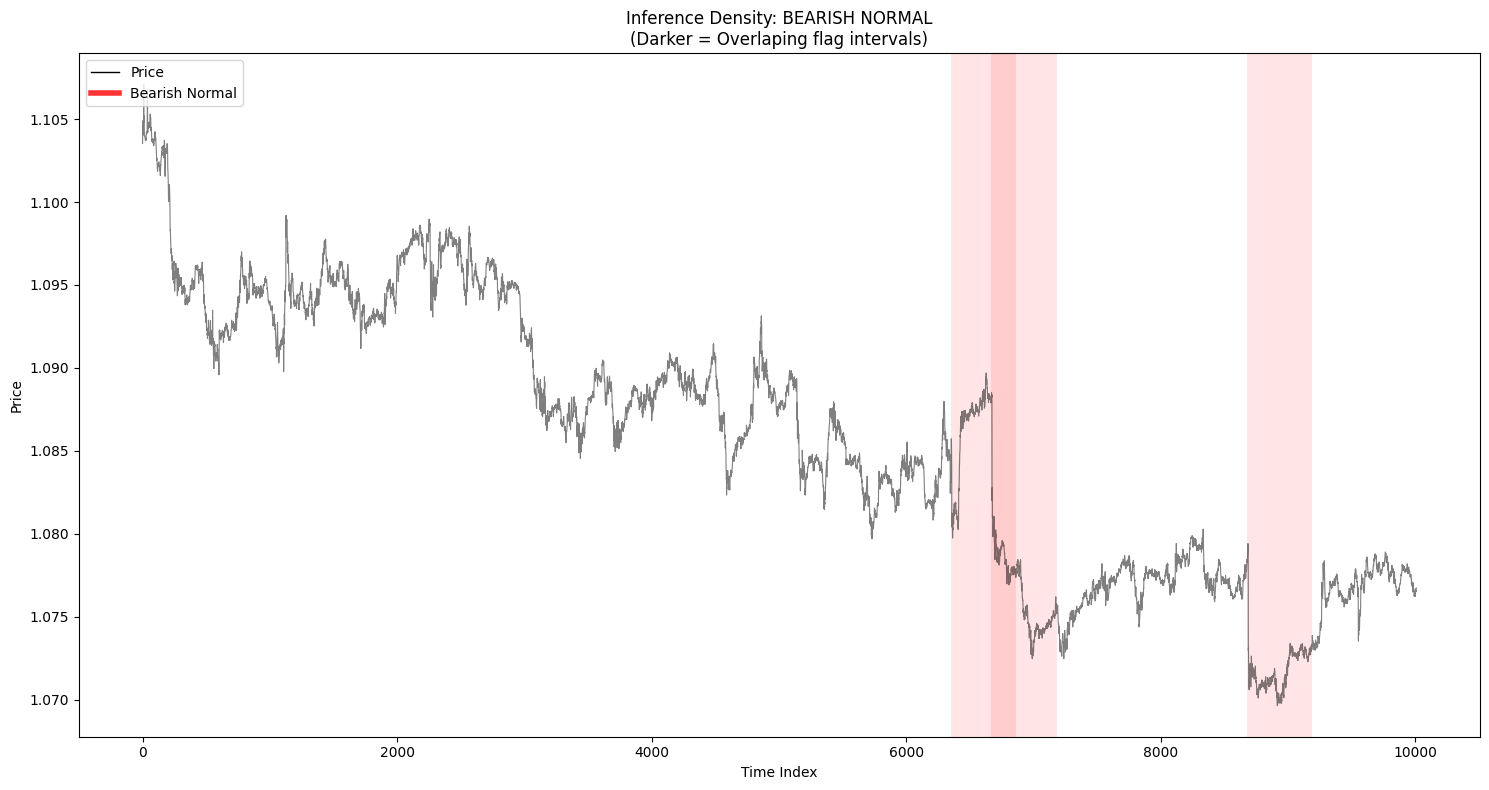

Generating plot for class [3]: Bullish Normal...


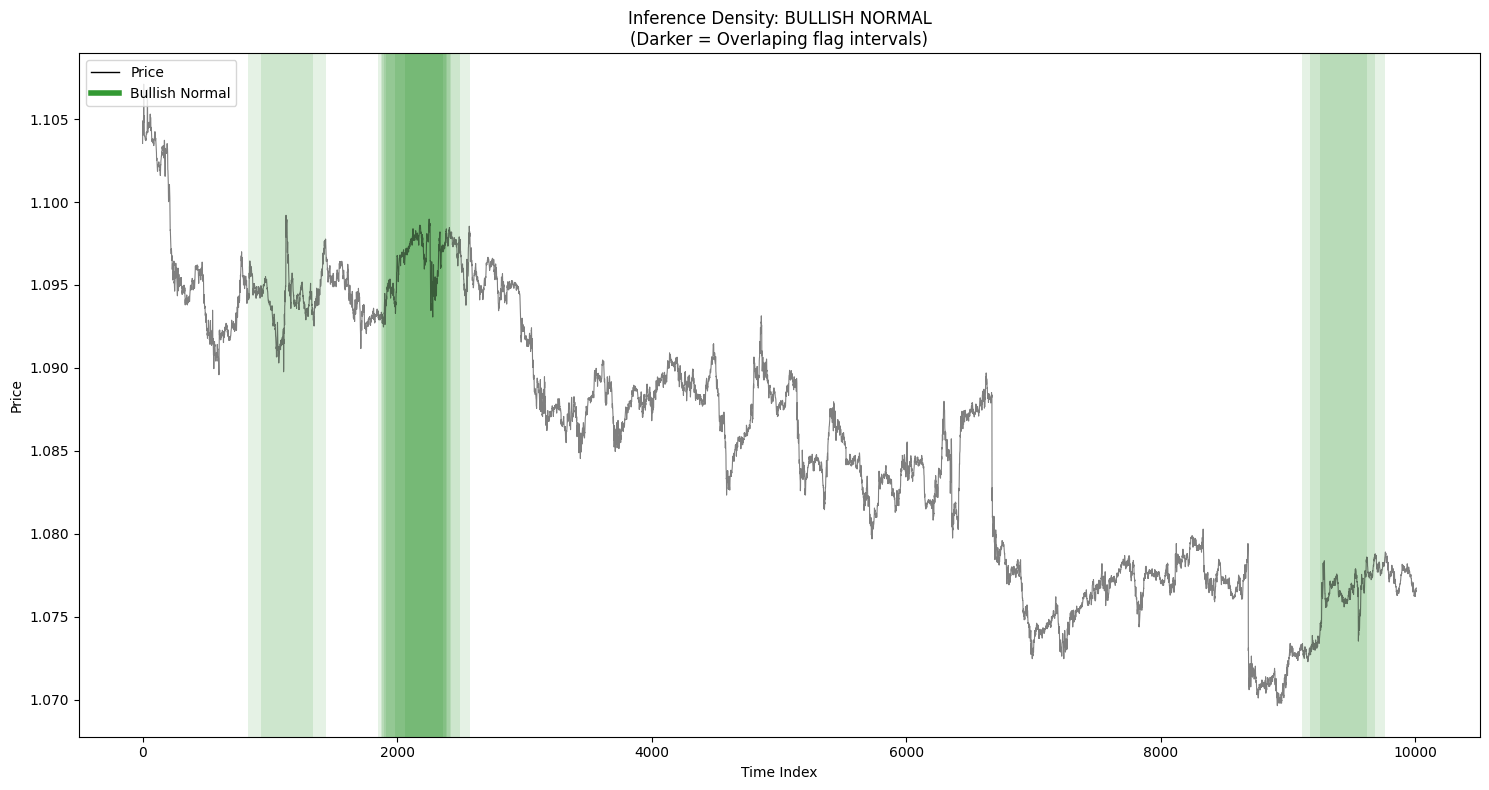

In [4]:
from lib.dataloader import FlagDataset
from lib.baseline_model import BaselineClassifier
from lib.model import FlagClassifier
from lib.seed_everything import seed_everything

seed_everything(config.SEED)

model = FlagClassifier(num_classes=6)
model.load_state_dict(torch.load(config.MODEL_LOAD_PATH, map_location=config.DEVICE))
input_df, pred_df = run_inference(model, "/app/inference/EURUSD_5min_002.csv", "temp_inference_results.csv")
plot_density_inference(input_df, pred_df)